# Import Data

In [53]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style(style = 'darkgrid')

import warnings
warnings.filterwarnings("ignore")

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential

from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split




In [54]:
#read the data in csv
df_sales = pd.read_csv('train.csv')

#convert date field from string to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'])

#show first 10 rows
df_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


We need the monthly sales data. Let's edit the date to the first date of each month and get the monthly wise sales.

In [55]:
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-' + '01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
display(df_sales)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,1,11
2,2013-01-01,1,1,14
3,2013-01-01,1,1,13
4,2013-01-01,1,1,10
...,...,...,...,...
912995,2017-12-01,10,50,63
912996,2017-12-01,10,50,59
912997,2017-12-01,10,50,74
912998,2017-12-01,10,50,62


In [56]:
df_sales = df_sales.groupby(['date'])['sales'].sum().reset_index()
display(df_sales)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


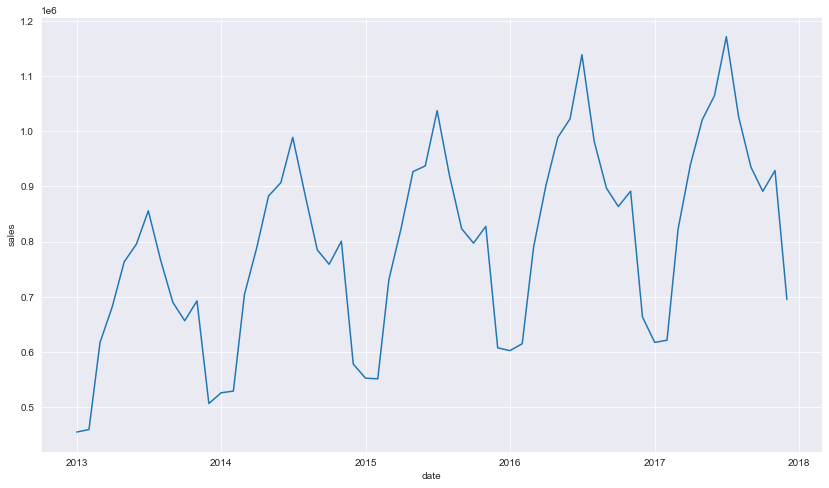

In [57]:
plt.figure(figsize=(14,8))
sns.lineplot(data = df_sales, x = 'date', y = 'sales')
plt.show()

# Data transformation

To apply LSTM to our model, we'll have to make sure that data is stationary and we have to convert it into supervised data to apply the feature modeling before we apply the LSTM.

<br>
As seen from the plot above, our data is not stationary and has an upward trend.
<br>
We can thus consider the difference in sales and construct our model which will then become stationary.

In [58]:
df_diff = df_sales.copy()
df_diff['prev_sales'] = df_diff['sales'].shift(1)
df_diff = df_diff.dropna()
df_diff['diff'] = df_diff['sales'] - df_diff['prev_sales']

display(df_diff)

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0
6,2013-07-01,855922,795597.0,60325.0
7,2013-08-01,766761,855922.0,-89161.0
8,2013-09-01,689907,766761.0,-76854.0
9,2013-10-01,656587,689907.0,-33320.0
10,2013-11-01,692643,656587.0,36056.0


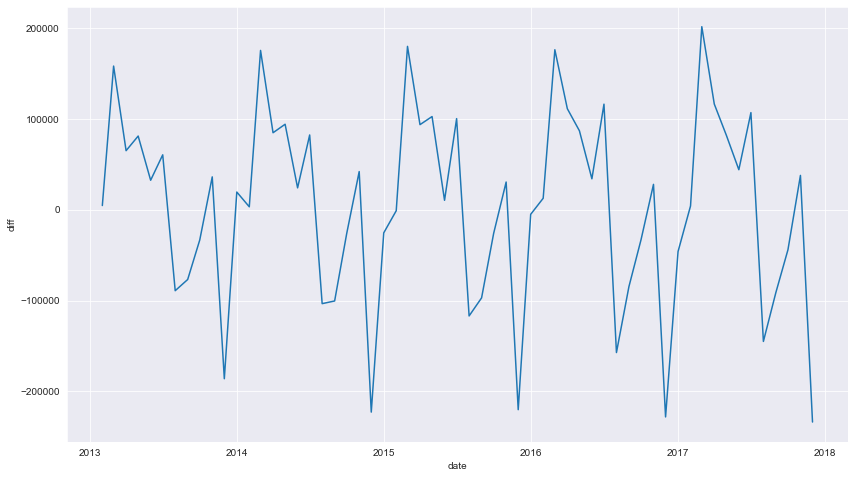

In [59]:
plt.figure(figsize = (14,8))
sns.lineplot(data = df_diff, x = 'date', y = 'diff')
plt.show()

Now the data seems to be stationary. Hence we can go forward with our prediction.
<br>
We need to build the feature set for the prediction.
<br>
The lookback period can vary from business to business. Here we'll be using 12 as the lookback period for predicting the future sales.

In [60]:
#converting dataframe from time series to supervised where we implement our feature set
df_supervised = df_diff.drop('prev_sales', axis = 1)

for i in range(1,13):
    col_name = 'lb_' + str(i) #lookback 'i' months
    df_supervised[col_name] = df_supervised['diff'].shift(i)

df_supervised = df_supervised.dropna().reset_index(drop = True)
display(df_supervised)

,date,sales,diff,lb_1,lb_2,lb_3,lb_4,lb_5,lb_6,lb_7,lb_8,lb_9,lb_10,lb_11,lb_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Now we need to find which feature varies our label and by how much
<br>
For this we will be using the adjusted R-square which is basically applying a Linear Regression model to the data.

In [61]:

import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lb_1 + lb_2 + lb_3 + lb_4 + lb_5 + lb_6 + lb_7 + lb_8 + lb_9 + lb_10 + lb_11 + lb_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.9795722233296558


We can surmise from the above quantity that all the 12 features that we have obtained from the previous months are a good estimation of our diff.

Now let's build our model after splitting the data and scaling it.

In [71]:
from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['sales','date'],axis=1)
display(df_model)
display(df_model[0:-6])
display(df_model[-6:])
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values
display(train_set)
print(train_set.shape)
display(test_set)
print(test_set.shape)

,diff,lb_1,lb_2,lb_3,lb_4,lb_5,lb_6,lb_7,lb_8,lb_9,lb_10,lb_11,lb_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


,diff,lb_1,lb_2,lb_3,lb_4,lb_5,lb_6,lb_7,lb_8,lb_9,lb_10,lb_11,lb_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


,diff,lb_1,lb_2,lb_3,lb_4,lb_5,lb_6,lb_7,lb_8,lb_9,lb_10,lb_11,lb_12
41,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0
42,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0
43,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0
44,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0
45,37677.0,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0
46,-233667.0,37677.0,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0


array([[   3130.,   19380., -186036.,   36056.,  -33320.,  -76854.,
         -89161.,   60325.,   32355.,   80968.,   64892.,  157965.,
           4513.],
       [ 175184.,    3130.,   19380., -186036.,   36056.,  -33320.,
         -76854.,  -89161.,   60325.,   32355.,   80968.,   64892.,
         157965.],
       [  84613.,  175184.,    3130.,   19380., -186036.,   36056.,
         -33320.,  -76854.,  -89161.,   60325.,   32355.,   80968.,
          64892.],
       [  93963.,   84613.,  175184.,    3130.,   19380., -186036.,
          36056.,  -33320.,  -76854.,  -89161.,   60325.,   32355.,
          80968.],
       [  23965.,   93963.,   84613.,  175184.,    3130.,   19380.,
        -186036.,   36056.,  -33320.,  -76854.,  -89161.,   60325.,
          32355.],
       [  82168.,   23965.,   93963.,   84613.,  175184.,    3130.,
          19380., -186036.,   36056.,  -33320.,  -76854.,  -89161.,
          60325.],
       [-103414.,   82168.,   23965.,   93963.,   84613.,  175184.,
  

(41, 13)


array([[ 106769.,   43938.,   81824.,  116195.,  201298.,    4063.,
         -46105., -228037.,   27811.,  -33194.,  -84663., -157224.,
         116054.],
       [-144990.,  106769.,   43938.,   81824.,  116195.,  201298.,
           4063.,  -46105., -228037.,   27811.,  -33194.,  -84663.,
        -157224.],
       [ -91140., -144990.,  106769.,   43938.,   81824.,  116195.,
         201298.,    4063.,  -46105., -228037.,   27811.,  -33194.,
         -84663.],
       [ -44103.,  -91140., -144990.,  106769.,   43938.,   81824.,
         116195.,  201298.,    4063.,  -46105., -228037.,   27811.,
         -33194.],
       [  37677.,  -44103.,  -91140., -144990.,  106769.,   43938.,
          81824.,  116195.,  201298.,    4063.,  -46105., -228037.,
          27811.],
       [-233667.,   37677.,  -44103.,  -91140., -144990.,  106769.,
          43938.,   81824.,  116195.,  201298.,    4063.,  -46105.,
        -228037.]])

(6, 13)


In [72]:

scaler = MinMaxScaler(feature_range=(-1, 1)) #to set the range of the feature between -1 and 1 after scaling
scaler = scaler.fit(train_set)

# reshape training set
# train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
# display(train_set)
# print(train_set.shape)
train_set_scaled = scaler.transform(train_set)
display(train_set_scaled)

# reshape test set
# test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)
display(test_set_scaled)

array([[ 0.07686073,  0.15255919, -0.80434393,  0.23024212, -0.0447346 ,
        -0.25830878, -0.3186859 ,  0.40696724,  0.26794062,  0.50957454,
         0.42966779,  0.8922929 ,  0.12955024],
       [ 0.8783514 ,  0.07686073,  0.15255919, -0.80434393,  0.29561828,
        -0.0447346 , -0.25830878, -0.33606217,  0.40696724,  0.26794062,
         0.50957454,  0.42966779,  0.8922929 ],
       [ 0.45643845,  0.8783514 ,  0.07686073,  0.15255919, -0.79394659,
         0.29561828, -0.0447346 , -0.27488947, -0.33606217,  0.40696724,
         0.26794062,  0.50957454,  0.42966779],
       [ 0.49999418,  0.45643845,  0.8783514 ,  0.07686073,  0.21380721,
        -0.79394659,  0.29561828, -0.05850103, -0.27488947, -0.33606217,
         0.40696724,  0.26794062,  0.50957454],
       [ 0.1739178 ,  0.49999418,  0.45643845,  0.8783514 ,  0.13408606,
         0.21380721, -0.79394659,  0.28633667, -0.05850103, -0.27488947,
        -0.33606217,  0.40696724,  0.26794062],
       [ 0.44504874,  0.173917

array([[ 0.55964922,  0.26695937,  0.44344626,  0.60355899,  1.10628178,
         0.13866328, -0.10745675, -1.02635392,  0.24535439, -0.05787474,
        -0.31370458, -0.67437352,  0.68397168],
       [-0.61313659,  0.55964922,  0.26695937,  0.44344626,  0.68877355,
         1.10628178,  0.13866328, -0.12204966, -1.02635392,  0.24535439,
        -0.05787474, -0.31370458, -0.67437352],
       [-0.36228353, -0.61313659,  0.55964922,  0.26695937,  0.52015228,
         0.68877355,  1.10628178,  0.12731349, -0.12204966, -1.02635392,
         0.24535439, -0.05787474, -0.31370458],
       [-0.14316792, -0.36228353, -0.61313659,  0.55964922,  0.33428672,
         0.52015228,  0.68877355,  1.10768225,  0.12731349, -0.12204966,
        -1.02635392,  0.24535439, -0.05787474],
       [ 0.23779333, -0.14316792, -0.36228353, -0.61313659,  0.64253037,
         0.33428672,  0.52015228,  0.68467253,  1.10768225,  0.12731349,
        -0.12204966, -1.02635392,  0.24535439],
       [-1.02622661,  0.237793

In [73]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [74]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 22s 3ms/step - loss: 0.4138
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.3556
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.2701
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.2178
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1831
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1589
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1411
Epoch 8/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1276
Epoch 9/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1169
Epoch 10/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1079
Epoch 11/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0999
Epoch 12/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0927
Epoch 13/100
41/41 [================

In [76]:
y_pred = model.predict(X_test,batch_size=1)

#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
    
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[ 0.64620268  0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.57265317  0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.39001989 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[-0.03246971 -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[ 0.20733136 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-0.99152249  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


In [77]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales
display(df_result)

,pred_value,date
0,1189973,2017-07-01
1,1035093,2017-08-01
2,929308,2017-09-01
3,914923,2017-10-01
4,922297,2017-11-01
5,702619,2017-12-01


In [78]:
display(df_sales)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


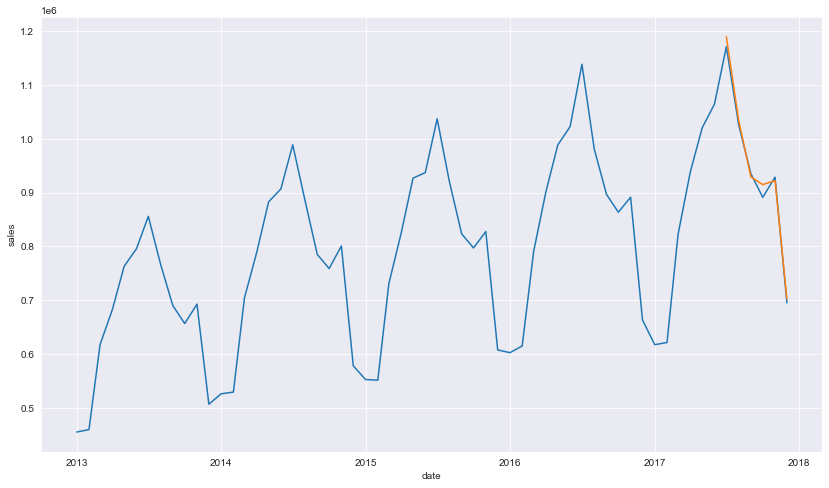

In [79]:
plt.figure(figsize = (14,8))
sns.lineplot(data = df_sales, x = 'date', y = 'sales')
sns.lineplot(data = df_result, x = 'date', y = 'pred_value')
plt.show()